# Проект: вариант 3

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

*Проверьте, был ли эксперимент успешен в целом.*

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.


Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

    uid – идентификатор пользователя
    age – возраст
    attraction_coeff – коэффициент привлекательности (от 0 до 1000, (лайки/просмотры)*1000)
    coins – число монеток (внутренняя валюта)
    country – страна  
    visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
    gender – пол
    age_filter_start  – фильтр поиска, мин. значение 
    age_filter_end  – фильтр поиска, макс. значение 
    views_count – число полученных оценок 
    was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
    is_premium –  является ли премиум
    total_revenue – нормированная выручка 

transactions_*.csv – информация о платежах пользователей:

    uid – идентификатор пользователя
    country – страна
    joined_at – дата и время регистрации
    paid_at – дата и время покупки
    revenue – нормированная выручка
    payment_id – идентификатор платежа
    from_page – откуда пользователь перешел на страницу оплаты
    product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 
   
**Файлы**:

    users_test – информация о пользователях в тестовой группе. 
    users_control_1 – информация о пользователях в первой контрольной группе. 
    users_control_2 – информация о пользователях во второй контрольной группе . 
    transactions_test – информация о платежах пользователей в тестовой группе. 
    transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 
    transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

In [1070]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2
import matplotlib.pyplot as plt

In [1071]:
# Загрузим все файлы
users_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/users_test.csv', sep=';')
users_control_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/users_control_2.csv', sep=';')
transactions_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/transactions_test.csv', sep=';', parse_dates=['joined_at','paid_at'])
transactions_control_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/transactions_control_1.csv', sep=';', parse_dates=['joined_at','paid_at'])
transactions_control_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/transactions_control_2.csv', sep=';', parse_dates=['joined_at','paid_at'])

## Предобработка данных
1. Для всех таблиц проверим:
   + Пропущенные значения;
   + Уникальность id между группами пользователей;
   + Дубликаты.
2. Отберем юзеров в контрольных и тестовой группе согласно условиям:
   + Выявим страны и платежные системы, для которых была введена новая стоимость оплаты, оставим только нужные;
   + Проверим даты проведения A/B теста и удалим выбросы на основе даты регистрации;
   + Проверим, что для всех пользователей регистрация произошла раньше, чем транзакция.
3. Оценим, насколько сбаласированы тестовая и контрольная группы по:
   + основным социо-демографическим показателям (возраст, пол);
   + показателям, специфичным для приложения (коэффициент привлекательности, число монет, число просмотров, число дней в приложении).
4. Сравним число пользователей и revenue из users и transactions

### Предобработка users (шаг 1)

In [1072]:
#Посмотрим на данные. Начнем с данных о пользователях контрольной группы
users_control_1.info()
users_control_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [1073]:
users_control_2.info()
users_control_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [1074]:
#Посмотрим на данные о пользователях из тестовой группы
users_test.info()
users_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


Поработаем с пропущенными значениями

In [1075]:
#Видим, что пропущенные в переменных coins, visit_days, was_premium, is_premium 
#Для всех переменных, кроме visit_days, посмотрим, какие значения возможны
users_control_1.coins.describe() #Здесь используем метод describe, чтобы посмотреть на минимальные значения

count       60.0000
mean      1745.9000
std      12902.3577
min          1.0000
25%          8.0000
50%         11.5000
75%         28.0000
max      99958.0000
Name: coins, dtype: float64

In [1076]:
users_control_1.was_premium.unique()

array([nan,  1.])

In [1077]:
users_control_1.is_premium.unique()

array([nan,  1.])

Видим, что, вероятнее всего, NaN в данном случае эквивалентно 0 - если монет/подписки нет, система это не фиксирует
visit_days - в какие дни после регистрации пользователь посещал приложение, также можем заменить на 0 (посещал только при регистрации)

In [1078]:
#Заменим NaN на 0 во всех таблицах для данных переменных

users_control_1[['coins','was_premium','is_premium', 'visit_days']]\
=users_control_1[['coins','was_premium','is_premium', 'visit_days']].fillna(0)

In [1079]:
#Проверим, что код работает, и сделаем то же самое с остальными датафреймами
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             4340 non-null   float64
 4   country           4340 non-null   object 
 5   visit_days        4340 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       4340 non-null   float64
 11  is_premium        4340 non-null   float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [1080]:
users_control_2[['coins','was_premium','is_premium', 'visit_days']]\
=users_control_1[['coins','was_premium','is_premium', 'visit_days']].fillna(0)
users_test[['coins','was_premium','is_premium', 'visit_days']]\
=users_test[['coins','was_premium','is_premium', 'visit_days']].fillna(0)

In [1081]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             4264 non-null   float64
 4   country           4264 non-null   object 
 5   visit_days        4264 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       4264 non-null   float64
 11  is_premium        4264 non-null   float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [1082]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             4308 non-null   float64
 4   country           4308 non-null   object 
 5   visit_days        4308 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       4308 non-null   float64
 11  is_premium        4308 non-null   float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


Теперь проверим, все ли id уникальны между двумя контрольными и тестовой группой. Т.е., проверим, что а) система сплитования корректно работает, б) в обеих таблицах с контрольной группой разные id, они не пересекаются

In [1083]:
test = set(users_test.uid)
control1 = set(users_control_1.uid)
control2 = set(users_control_2.uid)

test & control1 & control2

set()

Получили пустое множество. Значит, все id уникальны. Можем присвоить соответствующие обозначения: test, control1 и control 2.

In [1084]:
users_test['group'] = 'test'
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test


In [1085]:
users_control_1['group'] = 'control1'
users_control_2['group'] = 'control2'
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,0.0,0.0,0,control1
1,891248523,29,500,0.0,United States of America,"1,2",1,26,32,12,0.0,0.0,0,control1
2,891670932,33,800,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,0.0,0.0,0,control1
3,891060786,26,0,0.0,Argentina,"1,2,3,4,5",1,23,29,0,0.0,0.0,0,control1
4,892006554,35,294,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,0.0,0.0,0,control1


In [1086]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892035504,37,137,0.0,Israel,"1,2,3,4,5,6",1,30,40,51,0.0,0.0,0,control2
1,891782112,57,0,0.0,Italy,"1,2",1,54,60,0,0.0,0.0,0,control2
2,891110337,30,769,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,27,33,13,0.0,0.0,0,control2
3,891796320,48,750,0.0,France,"1,2,3,4,5",1,45,51,12,0.0,0.0,0,control2
4,891880212,54,638,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,35,53,94,0.0,0.0,0,control2


Объединим таблицы с данными пользователей.

In [1087]:
users = pd.concat([users_test, users_control_1, users_control_2], axis=0)\
.reset_index(drop=True) 

In [1088]:
#Проверяем, что все сработало корректно
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test


In [1089]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12912 entries, 0 to 12911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12912 non-null  int64  
 1   age               12912 non-null  int64  
 2   attraction_coeff  12912 non-null  int64  
 3   coins             12912 non-null  float64
 4   country           12912 non-null  object 
 5   visit_days        12912 non-null  object 
 6   gender            12912 non-null  int64  
 7   age_filter_start  12912 non-null  int64  
 8   age_filter_end    12912 non-null  int64  
 9   views_count       12912 non-null  int64  
 10  was_premium       12912 non-null  float64
 11  is_premium        12912 non-null  float64
 12  total_revenue     12912 non-null  int64  
 13  group             12912 non-null  object 
dtypes: float64(3), int64(8), object(3)
memory usage: 1.4+ MB


In [1090]:
users.group.unique()

array(['test', 'control1', 'control2'], dtype=object)

Теперь, когда все данные о пользователях собраны в одной таблице, проверим данные на наличие дубликатов

In [1091]:
users.loc[users.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group


Видим, что все данные уникальны

Осталось преобразовать переменную visit_days (в какие дни после регистрации пользователь посещал приложение). В текущем виде ее использование в анализе проблематично. Создадим 2 переменные: visit_number - число дней, в которые пользователь заходил в приложение; last_visit - через сколько дней после регистрации пользователь в последний раз посетил приложение

In [1092]:
#Разбиваем на элементы, считаем их число 
users['visit_number'] = users.visit_days.str.split(',').str.len()

In [1093]:
#Разделяем строку, берем последний элемент
users['last_visit'] = users.visit_days.str.split(',').str[-1]

In [1094]:
users.head() 

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,14.0,17
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,NaN,NaN
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,20.0,26
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,12.0,12
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,NaN,NaN


In [1095]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12912 entries, 0 to 12911
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12912 non-null  int64  
 1   age               12912 non-null  int64  
 2   attraction_coeff  12912 non-null  int64  
 3   coins             12912 non-null  float64
 4   country           12912 non-null  object 
 5   visit_days        12912 non-null  object 
 6   gender            12912 non-null  int64  
 7   age_filter_start  12912 non-null  int64  
 8   age_filter_end    12912 non-null  int64  
 9   views_count       12912 non-null  int64  
 10  was_premium       12912 non-null  float64
 11  is_premium        12912 non-null  float64
 12  total_revenue     12912 non-null  int64  
 13  group             12912 non-null  object 
 14  visit_number      8952 non-null   float64
 15  last_visit        8952 non-null   object 
dtypes: float64(4), int64(8), object(4)
memor

In [1096]:
#Посмотрим, откуда взялись пропущенные в новых переменных
users.query("visit_number=='NaN' | last_visit=='NaN'")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,NaN,NaN
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,NaN,NaN
6,891304281,39,0,0.0,France,0,1,36,42,0,0.0,0.0,0,test,NaN,NaN
7,892431420,21,909,0.0,Australia,0,1,18,24,11,0.0,0.0,0,test,NaN,NaN
13,891219699,30,1000,0.0,United States of America,0,1,27,33,1,1.0,0.0,0,test,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12885,891693531,26,0,0.0,Spain,0,1,23,29,1,0.0,0.0,0,control2,NaN,NaN
12896,891092556,24,0,0.0,Argentina,0,1,21,27,2,0.0,0.0,0,control2,NaN,NaN
12900,891332760,50,0,0.0,Chile,0,1,47,53,3,0.0,0.0,0,control2,NaN,NaN
12902,891693195,26,0,0.0,Spain,0,1,23,29,2,0.0,0.0,0,control2,NaN,NaN


In [1097]:
#Проверим, все ли пропущенные справедливы только для visit_days=0
users.query("visit_number=='NaN' & visit_days!=0")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit


In [1098]:
users.query("last_visit=='NaN' & visit_days!=0")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit


In [1099]:
#Заменим их на 0
users = users.fillna(0)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12912 entries, 0 to 12911
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12912 non-null  int64  
 1   age               12912 non-null  int64  
 2   attraction_coeff  12912 non-null  int64  
 3   coins             12912 non-null  float64
 4   country           12912 non-null  object 
 5   visit_days        12912 non-null  object 
 6   gender            12912 non-null  int64  
 7   age_filter_start  12912 non-null  int64  
 8   age_filter_end    12912 non-null  int64  
 9   views_count       12912 non-null  int64  
 10  was_premium       12912 non-null  float64
 11  is_premium        12912 non-null  float64
 12  total_revenue     12912 non-null  int64  
 13  group             12912 non-null  object 
 14  visit_number      12912 non-null  float64
 15  last_visit        12912 non-null  object 
dtypes: float64(4), int64(8), object(4)
memor

### Предобработка transactions (шаг 1)

In [1100]:
#Посмотрим на данные. Начнем с данных контрольной группы
transactions_control_1.info()
transactions_control_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 63.1+ KB


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [1101]:
#Видим, что много пустых строк, удалим их
transactions_control_1=transactions_control_1.dropna()

In [1102]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 26.5+ KB


In [1103]:
transactions_control_2.info()
transactions_control_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    int64         
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    int64         
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.6+ KB


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [1104]:
#Посмотрим на данные тестовой группы
transactions_test.info()
transactions_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    int64         
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    int64         
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 17.2+ KB


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


Видим, что в остальных датафреймах пропущенных значений нет. Проверим, что все таблицы содержат данные разных пользователей

In [1105]:
test_tr = set(transactions_test.uid)
control1_tr = set(transactions_control_1.uid)
control2_tr = set(transactions_control_2.uid)

test_tr & control1_tr & control2_tr #пользователи не пересекаются

set()

Проверим, что пользователи из таблиц users и transactions одни и те же

In [1106]:
test_tr - test

set()

In [1107]:
control1_tr - control1

set()

In [1108]:
control2_tr - control2

set()

Все в порядке. Проверим данные на наличие дубликатов и посмотрим, во всех ли строках уникальные пользователи

In [1109]:
transactions_test.loc[transactions_test.duplicated(keep=False)].sort_values('uid') 
#добавим параметр, который позволяет вывести оба дубликата, чтобы проверить код

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
15,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
158,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
80,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
179,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
205,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
17,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type


In [1110]:
#Дубликаты определены корректно, удаляем их
transactions_test = transactions_test.drop_duplicates()

In [1111]:
transactions_control_1.loc[transactions_control_1.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
47,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
88,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
93,891367521.0,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19.0,sympathy,other_type
169,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
176,892207959.0,France,2017-10-18 18:30:00,2017-10-22 04:49:00,1261.0,19.0,empty_likes,coins
198,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
206,891739737.0,United States of America,2017-10-28 18:50:00,2017-11-13 05:34:00,1261.0,19.0,empty_likes,coins
216,891452706.0,Italy,2017-03-11 14:48:00,2017-11-11 17:21:00,6305.0,19.0,gifts,coins
223,891721851.0,United States of America,2017-10-29 02:50:00,2017-11-14 04:08:00,897.0,19.0,empty_likes,coins
233,891365490.0,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261.0,19.0,empty_likes,coins


In [1112]:
transactions_control_1 = transactions_control_1.drop_duplicates()

In [1113]:
transactions_control_2.loc[transactions_control_2.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
86,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins
235,892064328,United States of America,2017-10-21 20:54:00,2017-10-22 01:30:00,6305,19,empty_likes,coins
241,892009254,Italy,2017-10-22 22:57:00,2017-10-23 00:06:00,2353,67,empty_likes,other_type
288,892062660,United States of America,2017-10-21 21:28:00,2017-10-31 00:53:00,1261,19,empty_likes,coins
321,892045743,Israel,2017-10-22 07:04:00,2017-10-23 20:17:00,1261,19,empty_likes,coins


In [1114]:
transactions_control_2 = transactions_control_2.drop_duplicates()

In [1115]:
transactions_test.uid.value_counts()

892236423    11
892065108     9
892057347     9
892339626     8
891861594     6
             ..
891904293     1
891907887     1
892354869     1
891867477     1
892071603     1
Name: uid, Length: 146, dtype: int64

In [1116]:
transactions_control_1.uid.value_counts()

892333905.0    19
892069554.0    11
891707061.0    10
892366260.0    10
892207959.0     7
               ..
891645606.0     1
892148454.0     1
891622389.0     1
891699369.0     1
891292845.0     1
Name: uid, Length: 193, dtype: int64

In [1117]:
transactions_control_2.uid.value_counts()

891637005    11
892230228    10
891080040     8
892139829     6
892128138     5
             ..
891482937     1
891924273     1
891592491     1
892149546     1
891075072     1
Name: uid, Length: 187, dtype: int64

Добавим переменную group и объединим все таблицы transactions в одну

In [1118]:
transactions_test['group'] = 'test'
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,test
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,test
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type,test
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type,test
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium,test


In [1119]:
transactions_control_1['group'] = 'control1'
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,control1
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,control1
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins,control1
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type,control1
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins,control1


In [1120]:
transactions_control_2['group'] = 'control2'
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins,control2
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial,control2
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium,control2
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type,control2
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial,control2


In [1121]:
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2], axis=0).reset_index(drop=True) 

In [1122]:
transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test


In [1123]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           945 non-null    float64       
 1   country       945 non-null    object        
 2   joined_at     945 non-null    datetime64[ns]
 3   paid_at       945 non-null    datetime64[ns]
 4   revenue       945 non-null    float64       
 5   payment_id    945 non-null    float64       
 6   from_page     945 non-null    object        
 7   product_type  945 non-null    object        
 8   group         945 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 66.6+ KB


### Отбор юзеров (шаг 2)

In [1124]:
#По условию стоимость подписки была изменена только для пользователей из нескольких стран
#Вначале отберем только пользователей из стран, встречающихся в тестовой группе, на основе users
countries_test=set(users.query("group=='test'").country)
countries_test

{'Algeria',
 'Argentina',
 'Australia',
 'Azerbaijan',
 'Belgium',
 'Bolivia',
 'Brazil',
 'Canada',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Dominican Republic',
 'Egypt',
 'France',
 'Gambia',
 'Georgia',
 'Germany',
 'Guatemala',
 'Hungary',
 'India',
 'Indonesia',
 'Iraq',
 'Islamic Republic of Iran',
 'Israel',
 'Italy',
 'Korea, Republic of',
 'Kyrgyzstan',
 'Latvia',
 'Mexico',
 'Monaco',
 'Morocco',
 'Nepal',
 'Pakistan',
 'Peru',
 'Philippines',
 'Portugal',
 'Puerto Rico',
 'Romania',
 'Russian Federation',
 'Singapore',
 'Spain',
 'Switzerland',
 'Tajikistan',
 'Tunisia',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America',
 'Uruguay',
 'Uzbekistan'}

In [1125]:
#Создадим новый датафрейм, в котором оставим только нужных пользователей
users_cleaned = users.query("country in @countries_test")

In [1126]:
users_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12887 entries, 0 to 12911
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12887 non-null  int64  
 1   age               12887 non-null  int64  
 2   attraction_coeff  12887 non-null  int64  
 3   coins             12887 non-null  float64
 4   country           12887 non-null  object 
 5   visit_days        12887 non-null  object 
 6   gender            12887 non-null  int64  
 7   age_filter_start  12887 non-null  int64  
 8   age_filter_end    12887 non-null  int64  
 9   views_count       12887 non-null  int64  
 10  was_premium       12887 non-null  float64
 11  is_premium        12887 non-null  float64
 12  total_revenue     12887 non-null  int64  
 13  group             12887 non-null  object 
 14  visit_number      12887 non-null  float64
 15  last_visit        12887 non-null  object 
dtypes: float64(4), int64(8), object(4)
memor

In [1127]:
#Теперь, оставив только нужные страны, сбалансируем группы, чтобы в контрольных и тестовой были пользователи из одних и тех же стран
countries_equal = set(users_cleaned.query("group=='test'").country) & set(users_cleaned.query("group=='control1'").country)\
& set(users_cleaned.query("group=='control2'").country)
countries_equal

{'Argentina',
 'Australia',
 'Belgium',
 'Canada',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Dominican Republic',
 'France',
 'Germany',
 'India',
 'Israel',
 'Italy',
 'Kyrgyzstan',
 'Mexico',
 'Peru',
 'Portugal',
 'Russian Federation',
 'Spain',
 'Switzerland',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America'}

In [1128]:
users_cleaned = users_cleaned.query("(group=='test' & country in @countries_equal)\
| (group=='control1' & country in @countries_equal)\
| (group=='control2' & country in @countries_equal)")

In [1129]:
#То же самое делаем для транзакций
transactions_cleaned = transactions.query("(group=='test' & country in @countries_equal)\
| (group=='control1' & country in @countries_equal)\
| (group=='control2' & country in @countries_equal)")

In [1130]:
#Выявим платежные системы, для которых проводился A/B тест. Их должно быть 0
transactions_cleaned.query("product_type == 'premium_no_trial' & group=='test'").payment_id.unique()

array([147.,  68.,   0.])

In [1131]:
#Видим 2 платежные системы и 0. Вероятно - пропущенное значение, посмотрим внимательнее
transactions_cleaned.query("product_type=='premium_no_trial' & payment_id==0")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
214,891725043.0,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217.0,0.0,none,premium_no_trial,test
401,891216033.0,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292.0,0.0,autoreply_message,premium_no_trial,control1
593,892101909.0,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422.0,0.0,none,premium_no_trial,control1
711,891219540.0,Australia,2017-07-11 10:50:00,2017-07-11 10:58:00,4719.0,0.0,none,premium_no_trial,control2


В тестовой группе должны быть транзакции через 2 платежные системы. Вероятнее всего, 0 - это ошибочное/не записанное значение. Удалим пользователей с этим значением, оставив только 147 и 68.

In [1132]:
transactions_cleaned = transactions_cleaned.query("payment_id in [147, 68]")
transactions_cleaned.query("product_type=='premium_no_trial' & group=='test'").payment_id.unique()

array([147.,  68.])

In [1133]:
#Создадим список нужных id
users_payment = transactions_cleaned.uid.unique()
len(users_payment)

449

Из таблиц users оставим всех пользователей, у которых total  revenue=0 (т.к. они не платили и платежными системами не пользовались, нам важно их не потерять) и всех платящих пользователей с платежной системой 147 и 68

In [1134]:
users_cleaned = users_cleaned.query("total_revenue==0 | (total_revenue>0 & uid in @users_payment)")
users_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12754 entries, 0 to 12911
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12754 non-null  int64  
 1   age               12754 non-null  int64  
 2   attraction_coeff  12754 non-null  int64  
 3   coins             12754 non-null  float64
 4   country           12754 non-null  object 
 5   visit_days        12754 non-null  object 
 6   gender            12754 non-null  int64  
 7   age_filter_start  12754 non-null  int64  
 8   age_filter_end    12754 non-null  int64  
 9   views_count       12754 non-null  int64  
 10  was_premium       12754 non-null  float64
 11  is_premium        12754 non-null  float64
 12  total_revenue     12754 non-null  int64  
 13  group             12754 non-null  object 
 14  visit_number      12754 non-null  float64
 15  last_visit        12754 non-null  object 
dtypes: float64(4), int64(8), object(4)
memor

Теперь посмотрим на даты, в которые пользователи регистрировались

In [1135]:
transactions_cleaned.query("group=='test'").joined_at.describe(datetime_is_numeric=True)

count                              138
mean     2017-09-05 09:47:50.869565184
min                2017-01-11 03:07:00
25%                2017-07-11 09:00:30
50%                2017-10-19 00:34:00
75%                2017-10-25 01:33:45
max                2017-10-31 23:40:00
Name: joined_at, dtype: object

In [1136]:
transactions_cleaned.query("group=='control1'").joined_at.describe(datetime_is_numeric=True)

count                              173
mean     2017-08-22 04:11:52.716763136
min                2017-01-11 01:06:00
25%                2017-06-11 14:03:00
50%                2017-10-16 22:33:00
75%                2017-10-22 14:04:00
max                2017-10-31 22:17:00
Name: joined_at, dtype: object

In [1137]:
transactions_cleaned.query("group=='control2'").joined_at.describe(datetime_is_numeric=True)

count                              157
mean     2017-09-06 20:10:32.101910784
min                2017-01-11 08:36:00
25%                2017-08-11 15:19:00
50%                2017-10-20 03:05:00
75%                2017-10-24 16:19:00
max                2017-10-31 17:43:00
Name: joined_at, dtype: object

Во всех группах пользователи, оставшиеся в датасете на данном шаге, зарегистрировались в январе 2017 г.

Проверим, для всех ли пользователей дата регистрации раньше, чем дата транзакции

In [1138]:
error = transactions_cleaned.query("joined_at>paid_at").uid.unique()
len(error)

79

У 79 пользователей регистрация произошла позднее, чем транзакция. Удалим их

In [1139]:
transactions_cleaned = transactions_cleaned.query("joined_at<paid_at")
uid_corrected = transactions_cleaned.uid.unique()
transactions_cleaned[['joined_at','paid_at']].head()

,joined_at,paid_at
0,2017-05-11 13:00:00,2017-11-13 15:04:00
1,2017-10-22 00:33:00,2017-10-30 01:37:00
4,2017-10-19 17:10:00,2017-10-27 19:10:00
5,2017-10-14 10:13:00,2017-10-15 22:39:00
6,2017-01-11 03:07:00,2017-10-11 09:05:00


In [1140]:
users_cleaned = users_cleaned.query("total_revenue == 0 | (total_revenue>0 & uid in @uid_corrected)")

In [1141]:
transactions_cleaned.groupby("group").uid.nunique()

group
control1    142
control2    125
test        107
Name: uid, dtype: int64

In [1142]:
users_cleaned.groupby("group").uid.nunique()

group
control1    4268
control2    4178
test        4233
Name: uid, dtype: int64

### Проверка сбалансированности групп (шаг 3)

Посмотрим, насколько сбалансированы тестовая и контрольные группы по основным социо-демографическим показателям. Для корректного сравнения важно, чтобы средний возраст и соотношение м/ж в выборках значимо не различались

Начнем со сравнения среднего возраста между тестовой и контрольными группами. Проверим соблюдение допущений для ANOVA. Поскольку группы достаточно большие (более 4000 наблюдений) и совпадают по размерам, соответствие нормальному распределению можно не проверять.

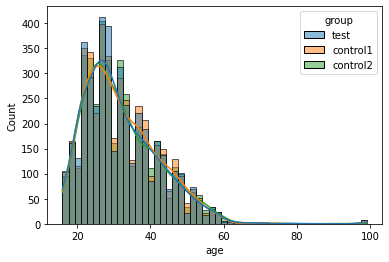

In [1143]:
#Посмотрим на графици и визуально оценим различия между группами
sns.histplot(data = users_cleaned, x ="age", hue = 'group', bins = 50, kde=True)

In [1144]:
#Посмотрим на описательные
users_cleaned.groupby('group').age.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control1,4268.0,32.083177,10.273384,16.0,24.0,30.0,38.0,99.0
control2,4178.0,32.040929,10.155766,16.0,25.0,30.0,38.0,99.0
test,4233.0,31.877156,10.275162,16.0,25.0,30.0,38.0,99.0


Видим, что среднее и разброс во всех группах приблизительно одинаковые, поэтому предполагаем, что группы эквивалентны по возрасту. Однако, необходимо оценить это статистически.

Несмотря на то, что из графиков и описательной статистики можно предположить, что дисперсии одинаковы, проверим гомогенность дисперсий при помощи критерия Ливиня

In [1145]:
pg.homoscedasticity(data=users_cleaned, dv="age", group="group")

,W,pval,equal_var
levene,0.300612,0.74037,True


Поскольку критерий Ливиня проверяет H0 - дисперсии не различаются и H1 - дисперсии различаются, делаем вывод о равенстве дисперсий.
Можем применять ANOVA. H0: средние значения возраста в группах не различаются, H1 - среднее значение возраста как минимум в одной группе отличается от среднего значения возраста в других группах 

In [1146]:
pg.anova(data=users_cleaned, dv="age", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12676,0.479191,0.619295,0.000076


Видим, что значимые различия отсутствуют. Следовательно, группы эквивалентны по возрасту. Проверим число мужчин и женщин в группах

In [1147]:
#Посмотрим, как представлен пол в данных
users_cleaned.groupby('group').gender.unique()
#Видим, что пол обозначен, как 0 и 1. Обычно 0 - женский пол, 1 - мужской, но нам информация не предоставлена

group
control1    [0, 1]
control2    [1, 0]
test        [1, 0]
Name: gender, dtype: object

In [1148]:
gender_number = users_cleaned.groupby('group')['gender'].value_counts().unstack()

In [1149]:
gender_number

gender,0,1
group,,
control1,181,4087
control2,193,3985
test,200,4033


In [1150]:
gender_number.div(gender_number.sum(axis=1), axis=0)

gender,0,1
group,,
control1,0.042409,0.957591
control2,0.046194,0.953806
test,0.047248,0.952752


Видим, что соотношение приблизительно равно, однако, преобладают респонденты с полом, закодированным, как 1 (мужчины?). Проверим статистически при помощи критерия Хи-квадрат (H0 - соотношение мужчин и женщин в выборке не различается между контрольными и тестовой группами , H1 - соотношение мужчин и женщин различается)

In [1151]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_cleaned.group, users_cleaned.gender))
stat, p

(1.2741691534678008, 0.5288319477352809)

Различия не значимы, нулевую гипотезу отклонить не можем. Тестовая и контрольные группы не различаются по соотношению мужчин и женщин.
Делаем вывод о том, что тестовая и контрольные группы сбалансированы по полу и возрасту.

Представляется важным также проверить, различаются ли показатели, связанные с ипользованием приложения: attraction_coefficient, coins, visit_number, views_count.

Воспользуемся ANOVA. Пользователей более 4000 в каждой из групп, поэтому на соответствие нормальному распределению проверять не обязательно

Но необходимо проверить равенство дисперсий (критерий Ливиня). H0 - дисперсии не различаются и H1 - дисперсии различаются.

In [1152]:
pg.homoscedasticity(data=users_cleaned, dv="attraction_coeff", group="group")

,W,pval,equal_var
levene,0.493188,0.610688,True


In [1153]:
pg.homoscedasticity(data=users_cleaned, dv="coins", group="group")

,W,pval,equal_var
levene,0.961387,0.38239,True


In [1154]:
pg.homoscedasticity(data=users_cleaned, dv="visit_number", group="group")

,W,pval,equal_var
levene,0.432524,0.648879,True


In [1155]:
pg.homoscedasticity(data=users_cleaned, dv="views_count", group="group")

,W,pval,equal_var
levene,0.868267,0.419703,True


Отклонить нулевую гипотезу не можем. Дисперсии значимо не различаются.

In [1156]:
#Посмотрим на описательные
users_cleaned.groupby('group').agg({'attraction_coeff':\
                                [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())],\
                                   'coins':\
                                 [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())]})

attraction_coeff                                              \
                     mean          sd mode median min   max  skewness   
group                                                                   
control1       311.906279  322.251948    0    235   0  1000  0.715475   
control2       316.280278  326.752131    0    241   0  1000  0.693819   
test           315.117883  323.889972    0    250   0  1000  0.703193   

                        coins                                         \
          kurtosis       mean           sd mode median  min      max   
group                                                                  
control1 -0.672567   0.988988    55.270709  0.0    0.0  0.0   3608.0   
control2 -0.739104  25.064624  1547.434000  0.0    0.0  0.0  99958.0   
test     -0.694691   2.475549   130.608449  0.0    0.0  0.0   8466.0   

                                  
           skewness     kurtosis  
group                             
control1  65.170012  4253.941764  
control2  64.513854  4167.094458  
test      64.350999  4169.518519

In [1157]:
#Посмотрим на описательные
users_cleaned.groupby('group').agg({'visit_number':\
                                 [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())],\
                                    'views_count':\
                                 [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                  ('kurtosis', lambda x: x.kurtosis())]})

visit_number                                                       \
                 mean        sd mode median  min   max  skewness  kurtosis   
group                                                                        
control1     4.566776  6.261693  0.0    2.0  0.0  31.0  1.833189  3.029265   
control2     4.645285  6.342516  0.0    2.0  0.0  31.0  1.809311  2.891300   
test         4.536735  6.155410  0.0    2.0  0.0  31.0  1.839156  3.094394   

         views_count                                                \
                mean          sd mode median min    max   skewness   
group                                                                
control1   41.966261  193.128791    0      6   0   4953  14.323385   
control2   43.207276  316.364024    0      5   0  16157  35.554887   
test       49.492086  319.038940    0      6   0  12831  23.141145   

                       
             kurtosis  
group                  
control1   278.066237  
control2  1667.296756  
test       735.653048

**Коэффициент привлекательности** H0 : Cредние значения коэффициента привлекательности в группах не различаются, H1 - среднее значение коэффициента привлекательности как минимум в одной группе отличается от среднего значения коэффициента привлекательности в других группах.

In [1158]:
pg.anova(data=users_cleaned, dv="attraction_coeff", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12676,0.20677,0.813209,0.000033


Различия не значимы, нулевую гипотезу отклонить не можем. Коэффициент привлекательности значимо не различается между группами.

**Число монет** H0 : Cредние значения числа монет в группах не различаются, H1 - среднее значение числа монет как минимум в одной группе отличается от среднего числа монет в других группах.

In [1159]:
pg.anova(data=users_cleaned, dv="coins", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12676,0.961387,0.38239,0.000152


Различия не значимы, нулевую гипотезу отклонить не можем. Число монет значимо не различается между группами.

**Число посещений приложения** H0 : Cредние значения посещений приложения в группах не различаются, H1 - среднее значение посещений приложения как минимум в одной группе отличается от среднего значения посещений приложения в других группах.

In [1160]:
pg.anova(data=users_cleaned, dv="visit_number", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12676,0.337436,0.713604,0.000053


Различия не значимы, нулевую гипотезу отклонить не можем. Число посещений приложения значимо не различается между группами.

**Число просмотров** H0 : Cредние значения числа просмотров в группах не различаются, H1 - среднее значение числа просмотров как минимум в одной группе отличается от среднего значения числа просмотров в других группах

In [1161]:
pg.anova(data=users_cleaned, dv="views_count", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12676,0.867511,0.420021,0.000137


Различия не значимы, нулевую гипотезу отклонить не можем. Число просмотров приложения значимо не различается между группами.

Таким образом, группы сбалансированы по всех социо-демографическим характеристикам и показателям использования приложения. В дальнейшем анализе можем использовать только одну контрольную группу

### Шаг 4

Проведем ряд дополнительных проверок для уточнения структуры данных, что нам необходимо для вычисления метрик

Проверим, действительно ли в таблице transactions находятся только пользователи, совершившие транзакцию, а в users - все

In [1162]:
transactions_cleaned.query('revenue==0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group


In [1163]:
users_cleaned.query('total_revenue==0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,14.0,17
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,0.0,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,20.0,26
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,12.0,12
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12907,891937401,63,242,0.0,Italy,1,1,50,66,33,0.0,0.0,0,control2,1.0,1
12908,891692844,35,500,0.0,France,"1,2,3,4,5,6,7",1,24,45,2,0.0,0.0,0,control2,7.0,7
12909,891096429,41,333,0.0,United States of America,"1,2",1,38,44,6,0.0,0.0,0,control2,2.0,2
12910,891697584,48,210,0.0,United Kingdom (Great Britain),2,1,45,51,19,0.0,0.0,0,control2,1.0,2


In [1164]:
(transactions_cleaned.uid.nunique() + users_cleaned.query('total_revenue==0').uid.nunique()) ==users_cleaned.uid.nunique() 

False

Получается, что если мы прибавим число уникальных пользователей, совершивших транзакцию, к пользователям, не совершавшим транзакцию, мы не получим общее число пользователей из таблицы users. Ищем источник расхождений

In [1165]:
(transactions_cleaned.uid.nunique() + users_cleaned.query('total_revenue==0').uid.nunique()) > users_cleaned.uid.nunique() 

True

Пользователей, совершивших транзакцию, больше, чем число пользователей из users_cleaned. Найдем их

In [1166]:
set(transactions_cleaned.uid.unique()) - set(users_cleaned.query('total_revenue>0').uid.unique())

{892355163.0}

In [1167]:
transactions_cleaned.query("uid == 892355163")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
553,892355163.0,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type,control1


In [1168]:
users_cleaned.query("uid == 892355163")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit
7678,892355163,40,640,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,0.0,0,control1,29.0,60


Общая выручка от одного пользователя обнулилась в users_cleaned, но отображается в transactions. Проверим, не записалась ли она на другого пользователя

In [1169]:
users_cleaned.query("total_revenue == 30264")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit


Таких пользователей нет. Однако, в total_revenune представлена нормированная выручка. Проверим, отличается ли она он суммы транзакций

In [1170]:
#Создадим датафрейм с суммой прибыли из транзакций, удалив пользователя 892355163

revenue_sum = transactions_cleaned.query("uid!=892355163").groupby(["group", "uid"]).agg({'revenue':'sum'}).reset_index()

#Создадим датафрейм с прибылью из данных о пользователях

total_revenue = users_cleaned.query('total_revenue>0').groupby(["group", "uid"]).agg({'total_revenue':'sum'}).reset_index()
len(revenue_sum) == len(total_revenue)

True

In [1171]:
#Число строк не различается. Смотрим дальше
transactions_cleaned.revenue.sum() - users_cleaned.total_revenue.sum()

-1586962.0

In [1172]:
#Сумма различается. Объединим датафреймы и проверим построчно
merged_df = revenue_sum.merge(total_revenue, 
           on=['uid', 'group'], how='outer')
merged_df

,group,uid,revenue,total_revenue
0,control1,891092322.0,5278.0,9945
1,control1,891120969.0,6292.0,6292
2,control1,891130164.0,4537.0,11869
3,control1,891131061.0,6292.0,10075
4,control1,891142386.0,4680.0,4680
...,...,...,...,...
368,test,892426491.0,12597.0,12597
369,test,892430988.0,12727.0,12727
370,test,892431081.0,9087.0,9087
371,test,892434141.0,3614.0,9165


In [1173]:
#сравним значения
merged_df['difference'] = merged_df['revenue'] - merged_df['total_revenue']

merged_df.query("difference!=0")

,group,uid,revenue,total_revenue,difference
0,control1,891092322.0,5278.0,9945,-4667.0
2,control1,891130164.0,4537.0,11869,-7332.0
3,control1,891131061.0,6292.0,10075,-3783.0
8,control1,891216033.0,6292.0,12584,-6292.0
13,control1,891252072.0,6292.0,8814,-2522.0
...,...,...,...,...,...
354,test,892248561.0,7254.0,38779,-31525.0
355,test,892261437.0,1937.0,3835,-1898.0
359,test,892339626.0,7774.0,17758,-9984.0
366,test,892405179.0,9100.0,13702,-4602.0


Видим, что есть расхождения с нормированной выручкой. Следовательно, мы знаем, что выручка от одного из пользователей = 30264 (не равна 0), но нам неизвестно, как именно выручку в users нормировали. Поэтому удалим этого пользователя

In [1174]:
users_cleaned = users_cleaned.query("uid != 892355163")
transactions_cleaned = transactions_cleaned.query("uid != 892355163")

In [1175]:
(transactions_cleaned.uid.nunique() + users_cleaned.query('total_revenue==0').uid.nunique()) ==users_cleaned.uid.nunique() 

True

In [1176]:
transactions_cleaned.uid.nunique() == users_cleaned.query('total_revenue>0').uid.nunique()

True

Ошибка исправлена. Делаем вывод о том, что все пользователи - это уникальные пользователи из users, платящие пользователи - это все пользователи из transactions. Далее будем ориентироваться на нормированные значения из users.

In [1177]:
#Проверим, какие типы product_type есть в датафрейме
transactions_cleaned.product_type.unique()

array(['trial_premium', 'premium_no_trial', 'other_type'], dtype=object)

In [1178]:
#Посмотрим, сколько теперь пользователей в каждой из групп
users_cleaned.query("total_revenue==0").group.value_counts()

test        4126
control1    4126
control2    4053
Name: group, dtype: int64

In [1179]:
users_cleaned.query("total_revenue>0").group.value_counts()

control1    141
control2    125
test        107
Name: group, dtype: int64

## Основной анализ данных
На данном этапе оценим эффективность эксперимента. Для этого нам будет достаточно трех метрик:
- ARPPU
- CR в премиум подписку
- Дополнительно оценим CR в пробную подписку, она не должна измениться

В качестве контрольной группы используем control1, т.к. группы были сбалансированы по всем характеристикам.
Будет проведено 3 попарных сравнения. Также, ниже будет представлен дополнительный анализ в сегментах пользователей: 2 группы по возрасту, 2 группы по стране. Поэтому p уровень значимости скорректирован на все 7 попарных сравнений.

In [1180]:
print(f" Следовательно, p = 0.05/7; p={0.05/7:.3f}")

 Следовательно, p = 0.05/7; p=0.007


### A/B тест

**1. ARPPU**

In [1181]:
ARPPU_calc = users_cleaned.query("(total_revenue>0) &(group=='test' | group=='control1')") #В датасете все пользователи уникальны, поэтому по ним не группируем

In [1182]:
ARPPU_calc

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit
20,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597,test,3.0,6
44,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,test,9.0,9
100,891343671,26,0,24.0,France,"1,2,3,4,5,6,7,8,9",1,23,35,37,1.0,1.0,21580,test,9.0,9
105,892430988,28,181,0.0,United States of America,"1,2",1,25,31,22,1.0,1.0,12727,test,2.0,2
134,891919368,29,250,0.0,France,0,1,26,32,4,1.0,1.0,16536,test,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,892104267,45,308,0.0,United States of America,"1,2,3,4",1,42,48,81,1.0,1.0,9087,control1,4.0,4
8517,891174534,49,0,0.0,Argentina,0,1,46,52,0,1.0,1.0,10517,control1,0.0,0
8522,891131061,23,192,0.0,Chile,"1,2,3,4,5,6",1,20,26,52,1.0,1.0,10075,control1,6.0,6
8539,891543996,50,508,0.0,United States of America,0,1,26,53,120,1.0,1.0,6292,control1,0.0,0


In [1183]:
#Посмотрим на описательные
ARPPU_calc.groupby('group').agg({'total_revenue':\
                                [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())]})

total_revenue                                                       \
                  mean            sd   mode median   min     max   skewness   
group                                                                         
control1  15006.978723  41253.814848   6292   9919  1508  486330  10.844778   
test      17676.355140  20084.268328  12727  12727  1898  129870   3.984904   

                      
            kurtosis  
group                 
control1  124.019076  
test       17.672723

В выборке имеются выбросы (пользователи с высоким чеком). Также, в каждой группе относительно мало пользователей (141 и 107). Следовательно, среднее арифметическое в данной ситуации некорректно оценивает средний доход с платящих пользователей. Однако, поскольку нам необходимо сравнить ARPPU, что является средним арифметическим, используем t-test

H0: ARPPU в контрольной и тестовой группе не различаются. H1: ARPPU с платящего пользователя в контрольной и тестовой группе различаются

In [1184]:
#Проверим дисперсии
#H0 - дисперсии не различаются, H1 - дисперсии различаются

pg.homoscedasticity(data=ARPPU, dv="total_revenue", group="group")

,W,pval,equal_var
levene,0.000139,0.990617,True


In [1185]:
#Дисперсии не различаются, используем t-test
test = ARPPU.query("group == 'test'").total_revenue
controll = ARPPU.query("group == 'control1'").total_revenue
ss.ttest_ind(control, test)

Ttest_indResult(statistic=-0.6160042312241603, pvalue=0.538461277568685)

**Вывод**. p value выше обозначенного порога, следовательно, отклоняем нулевую гипотезу. Увеличение стоимости премиум-подписки значимо не изменило ARPPU.

**2. CR**

Оценим конверсию в премиум подписку и пробную подписку. Конверсию можно оценивать при помощи критерия хи-квадрат. Приведем данные к виду: 1 - пользователь, который приобрел соответствующий тип подписки в период эксперимента, 0 - пользователь не приобрел соответствующий тип подписки). Подготовим данные.

In [1186]:
#Создадим датасет, который включает только пользователей с пробной подпиской
trial_premium = transactions_cleaned\
.query("product_type == 'trial_premium'").groupby(['uid', 'group'], as_index = False).agg(trial = ('product_type', 'nunique'))

In [1187]:
trial_premium

,uid,group,trial
0,891174411.0,test,1
1,891174534.0,control1,1
2,891175032.0,control1,1
3,891178713.0,control1,1
4,891206280.0,control2,1
...,...,...,...
125,892423284.0,control1,1
126,892430988.0,test,1
127,892431081.0,test,1
128,892438635.0,test,1


In [1188]:
#Создадим датасет, который включает только пользователей с премиум подпиской
premium = transactions_cleaned\
.query("product_type == 'premium_no_trial'").groupby(['uid', 'group'], as_index = False).agg(premium = ('product_type', 'nunique'))

In [1189]:
premium

,uid,group,premium
0,891068079.0,control2,1
1,891071157.0,test,1
2,891077727.0,control2,1
3,891092322.0,control1,1
4,891112263.0,control2,1
...,...,...,...
235,892405224.0,control1,1
236,892421277.0,control1,1
237,892426491.0,test,1
238,892434141.0,test,1


In [1190]:
#Соединим датасеты
#Используем full outer join, чтобы пользователи без подписки не удалились
subscriptions = trial_premium.merge(premium, on = ['uid', 'group'], how = 'outer')

In [1191]:
#Заменим NaN 0 - значит, подписки нет
subscriptions = subscriptions.fillna(0)

In [1192]:
subscriptions

,uid,group,trial,premium
0,891174411.0,test,1.0,0.0
1,891174534.0,control1,1.0,0.0
2,891175032.0,control1,1.0,0.0
3,891178713.0,control1,1.0,0.0
4,891206280.0,control2,1.0,0.0
...,...,...,...,...
365,892405224.0,control1,0.0,1.0
366,892421277.0,control1,0.0,1.0
367,892426491.0,test,0.0,1.0
368,892434141.0,test,0.0,1.0


In [1193]:
conversion = users_cleaned.merge(subscriptions, on = ['uid', 'group'], how = 'outer')
conversion = conversion.fillna(0)

In [1194]:
conversion  = conversion[['uid', 'group','trial','premium']]

In [1195]:
#Проверим, что все сработало корректно
conversion.trial.value_counts()

0.0    12548
1.0      130
Name: trial, dtype: int64

In [1196]:
conversion.premium.value_counts()

0.0    12438
1.0      240
Name: premium, dtype: int64

Приступаем к анализу при помощи критерия хи-квадрат Пирсона. Вначале проверим премиум подписку. H0 - конверсия в премиум подписку не различается между тестовой и контрольной группами, H1 - конверсия в премиум подписку различается между тестовой и контрольной группами группами.

In [1197]:
#Сформируем таблицу сопряженности
conversion_AB = conversion.query("group=='test' | group=='control1'")
pd.crosstab(conversion_AB.group, conversion_AB.premium)

premium,0.0,1.0
group,,
control1,4178,89
test,4174,59


In [1198]:
premium_rate = conversion_AB.groupby('group').premium.value_counts().unstack()
premium_rate.div(premium_rate.sum(axis=1), axis=0)

premium,0.0,1.0
group,,
control1,0.979142,0.020858
test,0.986062,0.013938


In [1199]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(conversion_AB.group, conversion_AB.premium))
stat, p

(5.549514519683896, 0.018485813570324246)

**Вывод**. p уровень значимости выше обозначенного порога 0.007, следовательно, нет оснований отклонить нулевую гипотезу. Изменение стоимости премиум подписки не способствовало значимому изменению конверсии в премиум подписку

Проверим пробную подписку. H0 - конверсия в пробную подписку не различается между контрольной и тестовой группами, H1 - конверсия в пробную подписку различается между контрольной и тестовой группами.

In [1200]:
pd.crosstab(conversion_AB.group, conversion_AB.trial)

trial,0.0,1.0
group,,
control1,4216,51
test,4187,46


In [1201]:
trial_rate_AB = conversion_AB.groupby('group').trial.value_counts().unstack()
trial_rate_AB.div(trial_rate_AB.sum(axis=1), axis=0)

trial,0.0,1.0
group,,
control1,0.988048,0.011952
test,0.989133,0.010867


In [1202]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(conversion_AB.group, conversion_AB.trial))
stat, p

(0.1360552359900586, 0.7122345688538869)

**Вывод**. Результат не значим, следовательно, у нас отсутствуют основания отклонить нулевую гипотезу. Изменение стоимости премиум подписки не повлияло значимо на конверсию в пробную подписку.

Таким образом, увеличение стоимости премиум-подписки значимо не повлияло на ARPPU и конверсию.

## **Тестирование гипотез на сегментах пользователей**

Посмотрим на сегменты пользователей по возрасту и стране, чтобы выявить, различается ли эффект в зависимости от сегмента - возможно, есть сегмент, для которого метрики значимо изменились

In [1203]:
segments_df = users_cleaned[['uid','group','age','country','total_revenue']].query("group=='test' | group=='control1'")

In [1204]:
segments_df

,uid,group,age,country,total_revenue
0,892309896,test,27,United States of America,0
1,892044516,test,27,Germany,0
2,892185708,test,45,Israel,0
3,892130292,test,32,United States of America,0
4,891406035,test,27,France,0
...,...,...,...,...,...
8643,892022304,control1,26,United States of America,0
8644,891905022,control1,38,Argentina,0
8645,891304722,control1,49,United States of America,0
8646,891302328,control1,27,United States of America,0


### **Выделение сегментов**

**Возраст**

In [1205]:
segments_df.groupby('group').age.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control1,4267.0,32.081322,10.273873,16.0,24.0,30.0,38.0,99.0
test,4233.0,31.877156,10.275162,16.0,25.0,30.0,38.0,99.0


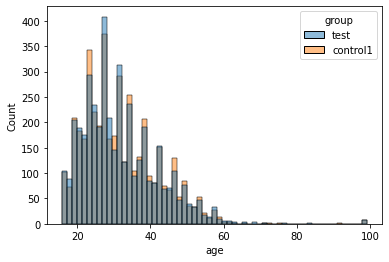

In [1206]:
sns.histplot(data = segments_df, x='age', hue = 'group')

In [1207]:
#Выбросы сосредоточены преимущественно в возрасте > 60 лет
segments_df.query("age>60").groupby(['group','age']).size()

group     age
control1  61     2
          62     1
          63     1
          66     2
          71     2
          72     1
          73     1
          75     1
          91     1
          98     1
          99     7
test      61     3
          62     2
          63     3
          65     3
          68     1
          69     3
          71     1
          76     1
          77     1
          83     1
          98     1
          99     7
dtype: int64

Мы не можем гарантировать, что юзеры корректно указывали возраст, но большое число пользователей с возрастом выше 99 выглядит подозрительно. При этом, в каждом из возрастов старше 80 и моложе 99 лет находится по 1 человеку. Поскольку для сравнения возрастных групп нам важно обеспечить корректность заявленного возраста, точно необходимо удалить всех пользователей 99 лет, как явно неправильные данные. 

In [1208]:
#Еще раз посмотрим на описательные
segments_df.groupby('group').age.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control1,4267.0,32.081322,10.273873,16.0,24.0,30.0,38.0,99.0
test,4233.0,31.877156,10.275162,16.0,25.0,30.0,38.0,99.0


Посмотрим границы, вычисленные на основе IQR (interquartile range)

In [1209]:
control_lower_bound = 24 - (38-24)*1.5
control_upper_bound = 38 + (38-24)*1.5
test_lower_bound = 25 - (38-25)*1.5
test_upper_bound = 38 + (38-25)*1.5

In [1210]:
control_lower_bound, control_upper_bound

(3.0, 59.0)

In [1211]:
test_lower_bound, test_upper_bound

(5.5, 57.5)

Получается, что если удалять выбросы на основе +/- 1.5 IQR (Interquartile range), можно отсечь важную часть пользователей: у нас достаточно много пользователей в возрасте 60+, что вряд ли является намеренно искаженными данными. Поэтому будем ориентироваться на представления о целевой аудитории приложений для знакомств и нашими данными, в которых лишь единичные пользователи находятся в возрасте 75+. Посмотрим на описательные в случае, если мы отберем всех пользователей до 75 лет включительно. 

In [1212]:
segments_df.query("age<=75").groupby('group').age.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control1,4258.0,31.941992,9.826313,16.0,24.0,30.0,38.0,75.0
test,4222.0,31.716959,9.785605,16.0,25.0,30.0,38.0,71.0


Медианное значение возраста 30 лет. Поскольку квартили находятся достаточно близко по возрастным границам, а также для снижения числа множественных сравнений, разделим пользователей по возрасту условно на 2 группы: до 30 лет включительно и старше 30 лет (до 75 включительно). Остальных оставим как NaN

In [1213]:
segments_df['age_group'] = segments_df.age\
.apply(lambda x: 1 if x<=30\
               else 2 if 30<x <= 75 else None)

In [1214]:
segments_df.age_group.unique()

array([ 1.,  2., nan])

**Страны**

In [1215]:
segments_df.groupby(['group', 'country'], as_index = False).size()

,group,country,size
0,control1,Argentina,385
1,control1,Australia,49
2,control1,Belgium,107
3,control1,Canada,132
4,control1,Chile,284
5,control1,Colombia,1
6,control1,Costa Rica,1
7,control1,Dominican Republic,2
8,control1,France,363
9,control1,Germany,187


In [1216]:
segments_df.country.unique()

array(['United States of America', 'Germany', 'Israel', 'France', 'Spain',
       'Australia', 'Italy', 'Argentina', 'Belgium', 'Chile', 'Portugal',
       'United Kingdom (Great Britain)', 'United Arab Emirates', 'Canada',
       'Ukraine', 'Switzerland', 'Mexico', 'Turkey', 'Russian Federation',
       'India', 'Peru', 'Kyrgyzstan', 'Colombia', 'Dominican Republic',
       'Costa Rica'], dtype=object)

Страны разделим на 2 группы, по классификации МВФ (Международного валютного фонда). В нашем контексте это то, что нужно, т.к. такая классификация учитывает уровень жизни.

1. Развитые страны:
    + United States of America
    + Germany
    + France
    + United Kingdom (Great Britain)
    + Canada
    + Australia
    + Switzerland
    + Belgium
    + Israel
    + Spain
    + Italy
    + Portugal
    
2. Развивающиеся страны:
   + Turkey
   + Russian Federation
   + India
   + Argentina
   + Chile
   + Peru
   + Colombia
   + Dominican Republic
   + Costa Rica
   + Ukraine
   + Kyrgyzstan
   + United Arab Emirates
   + Mexico

In [1217]:
#2
developed = ['United States of America','Germany','France','United Kingdom (Great Britain)','Canada','Australia','Switzerland','Belgium','Israel','Spain', 'Italy','Portugal']
#1
developing = ['Turkey','Russian Federation','India','Argentina','Chile','Peru','Colombia','Dominican Republic','Costa Rica','Ukraine','Kyrgyzstan','United Arab Emirates', 'Mexico']

In [1218]:
segments_df['country_group'] = segments_df.country\
.apply(lambda x: 1 if x in developing\
               else 2 if x in developed else None)

In [1219]:
segments_df.country_group.unique()

array([2, 1])

**Подготовим датасеты**

In [1220]:
#Датасет для ARPPU
segments_ARPPU = segments_df.query('total_revenue>0')
segments_ARPPU

,uid,group,age,country,total_revenue,age_group,country_group
20,891152790,test,29,Spain,12597,1.0,2
44,891589239,test,21,Italy,37817,1.0,2
100,891343671,test,26,France,21580,1.0,2
105,892430988,test,28,United States of America,12727,1.0,2
134,891919368,test,29,France,16536,1.0,2
...,...,...,...,...,...,...,...
8497,892104267,control1,45,United States of America,9087,2.0,2
8517,891174534,control1,49,Argentina,10517,2.0,1
8522,891131061,control1,23,Chile,10075,1.0,1
8539,891543996,control1,50,United States of America,6292,2.0,2


In [1221]:
#Проверим, что число строк совпадает
conversion_AB.shape[0]==segments_df.shape[0]

True

In [1222]:
segments_conversion = conversion_AB.merge(segments_df, on=['uid','group'])

In [1223]:
segments_conversion

,uid,group,trial,premium,age,country,total_revenue,age_group,country_group
0,892309896,test,0.0,0.0,27,United States of America,0,1.0,2
1,892044516,test,0.0,0.0,27,Germany,0,1.0,2
2,892185708,test,0.0,0.0,45,Israel,0,2.0,2
3,892130292,test,0.0,0.0,32,United States of America,0,2.0,2
4,891406035,test,0.0,0.0,27,France,0,1.0,2
...,...,...,...,...,...,...,...,...,...
8495,892022304,control1,0.0,0.0,26,United States of America,0,1.0,2
8496,891905022,control1,0.0,0.0,38,Argentina,0,2.0,1
8497,891304722,control1,0.0,0.0,49,United States of America,0,2.0,2
8498,891302328,control1,0.0,0.0,27,United States of America,0,1.0,2


### **Анализ**

**ARPPU**

Вначале анализируем **возрастные группы**

In [1224]:
segments_ARPPU_younger = segments_ARPPU.query("age_group==1")
segments_ARPPU_rev_older = segments_ARPPU.query("age_group==2")

In [1225]:
#Сравним дисперсию. H0 - дисперсия не различается, H1 - дисперсия различается
pg.homoscedasticity(data=segments_ARPPU_younger, dv="total_revenue", group="group")

,W,pval,equal_var
levene,0.106256,0.744964,True


Дисперсии не различаются, используем t-test. H0: ARPPU контрольной и тестовой групп среди пользователей до 30 лет не различаются. H1 - ARPPU различаются.

In [1226]:
test = segments_ARPPU_younger.query("group == 'test'").total_revenue
controll = segments_ARPPU_younger.query("group == 'control1'").total_revenue
ss.ttest_ind(control, test)

Ttest_indResult(statistic=-0.501911785651844, pvalue=0.6163200155821589)

In [1227]:
#Сравним дисперсию. H0 - дисперсия не различается, H1 - дисперсия различается
pg.homoscedasticity(data=segments_ARPPU_older, dv="total_revenue", group="group")

,W,pval,equal_var
levene,2.113428,0.148859,True


H0: ARPPU контрольной и тестовой групп среди пользователей старше 30 лет не различаются. H1 - ARPPU различаются.

In [1228]:
test = segments_ARPPU_rev_older.query("group == 'test'").total_revenue
controll = segments_ARPPU_rev_older.query("group == 'control1'").total_revenue
ss.ttest_ind(control, test)

Ttest_indResult(statistic=-0.3154665460408232, pvalue=0.7527413812774886)

**Вывод**. В обеих возрастных группах ARPPU значимо не изменилась

Проанализируем **страны**

In [1229]:
segments_ARPPU_developing = segments_ARPPU.query("country_group==1")
segments_ARPPU_developed = segments_ARPPU.query("country_group==2")

In [1230]:
#Сравним дисперсию. H0 - дисперсия не различается, H1 - дисперсия различается
pg.homoscedasticity(data=segments_ARPPU_developing, dv="total_revenue", group="group")

,W,pval,equal_var
levene,2.180791,0.147773,True


Дисперсии не различаются, используем t-test. H0: ARPPU контрольной и тестовой групп среди пользователей из развивающихся стран не различаются. H1 - ARPPU различается.

In [1231]:
test = segments_ARPPU_developing.query("group == 'test'").total_revenue
controll = segments_ARPPU_developing.query("group == 'control1'").total_revenue
ss.ttest_ind(control, test)

Ttest_indResult(statistic=-0.9183135695947473, pvalue=0.35985444904721986)

In [1232]:
#Сравним дисперсию. H0 - дисперсия не различается, H1 - дисперсия различается
pg.homoscedasticity(data=segments_ARPPU_developed, dv="total_revenue", group="group")

,W,pval,equal_var
levene,0.178436,0.673164,True


Дисперсии не различаются, используем t-test. H0: ARPPU контрольной и тестовой групп среди пользователей из развитых стран не различаются. H1 - ARPPU различается.

In [1233]:
test = segments_ARPPU_developed.query("group == 'test'").total_revenue
controll = segments_ARPPU_developed.query("group == 'control1'").total_revenue
ss.ttest_ind(control, test)

Ttest_indResult(statistic=-0.2807006230125321, pvalue=0.7791956955744741)

**Вывод** С изменением стоимости премиум-подписки ARPPU в сегментах пользователей значимо не изменилась

**Conversion**

**Возрастные группы**

In [1234]:
segments_conversion_younger = segments_conversion.query("age_group==1")
segments_conversion_older = segments_conversion.query("age_group==2")

H0 - конверсия в премиум подписку не различается между пользователями тестовой и контрольной групп до 30 лет, H1 - конверсия в премиум подписку различается между пользователями тестовой и контрольной групп до 30 лет.

In [1235]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(segments_conversion_younger.group, segments_conversion_younger.premium))

stat, p

(11.551028450376572, 0.0006771179135933891)

In [1236]:
younger_prem_rate_control = segments_conversion_younger.query("group=='control1'").premium.sum() / segments_conversion_younger.query("group=='control1'").premium.count()
younger_prem_rate_test = segments_conversion_younger.query("group=='test'").premium.sum() / segments_conversion_younger.query("group=='test'").premium.count()

In [1237]:
younger_prem_rate_control

0.02585034013605442

In [1238]:
younger_prem_rate_test

0.011601963409192326

**Вывод**. p уровень значимости ниже порога 0.005, следовательно, можем отклонить нулевую гипотезу. Изменение стоимости премиум подписки значимо повлияло на конверсию в премиум подписку для пользователей до 30 лет.

In [1239]:
print(f" Увеличение стоимости премиум-подписки способствовало уменьшению конверсии пользователей до 30 лет в премиум подписку на\
 {abs((younger_prem_rate_test-younger_prem_rate_control) / younger_prem_rate_control * 100).round(2)}%")

 Увеличение стоимости премиум-подписки способствовало уменьшению конверсии пользователей до 30 лет в премиум подписку на 55.12%


H0 - конверсия в премиум подписку не различается между пользователями тестовой и контрольной групп старше 30 лет, H1 - конверсия в премиум подписку различается между пользователями тестовой и контрольной групп старше 30 лет.

In [1240]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(segments_conversion_older.group, segments_conversion_older.premium))

stat, p

(0.0728887530965704, 0.7871762774663089)

**Вывод**. Результат не значим, следовательно, у нас отсутствуют основания отклонить нулевую гипотезу. Изменение стоимости премиум подписки не повлияло значимо на конверсию в премиум подписку для пользователей 30+.

**Страны**

In [1241]:
segments_conversion_developing = segments_conversion_younger.query("country_group==1")
segments_conversion_developed = segments_conversion_younger.query("country_group==2")

H0 - конверсия в премиум подписку не различается между пользователями тестовой и контрольной групп из развивающихся стран, H1 - конверсия в премиум подписку различается между пользователями тестовой и контрольной групп из развивающихся стран.

In [1242]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(segments_conversion_developing.group, segments_conversion_developing.premium))

stat, p

(0.056563620071684584, 0.8120121159884117)

**Вывод**. Результат не значим, следовательно, у нас отсутствуют основания отклонить нулевую гипотезу. Изменение стоимости премиум подписки не повлияло значимо на конверсию в премиум подписку для пользователей из развивающихся стран.

H0 - конверсия в премиум подписку не различается между пользователями тестовой и контрольной групп из развитых стран, H1 - конверсия в премиум подписку различается между пользователями тестовой и контрольной групп из развитых стран.

In [1243]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(segments_conversion_developed.group, segments_conversion_developed.premium))

stat, p

(12.900841577506583, 0.0003284344225033169)

In [1244]:
conversion_developed_c = segments_conversion_developed.query("group=='control1'").premium.sum() / segments_conversion_developed.query("group=='control1'").premium.count()
conversion_developed_t = segments_conversion_developed.query("group=='test'").premium.sum() / segments_conversion_developed.query("group=='test'").premium.count()

In [1245]:
conversion_developed_c

0.027647058823529413

In [1246]:
conversion_developed_t

0.010368663594470046

**Вывод**. p уровень значимости ниже порога 0.005, следовательно, можем отклонить нулевую гипотезу. Изменение стоимости премиум подписки значимо повлияло на конверсию в премиум подписку для пользователей из развитых стран.

In [1247]:
print(f" Увеличение стоимости премиум-подписки способствовало уменьшению конверсии в премиум подписку на\
 {abs((conversion_developed_t-conversion_developed_c) / conversion_developed_c * 100).round(2)}%")

 Увеличение стоимости премиум-подписки способствовало уменьшению конверсии в премиум подписку на 62.5%


### Выводы по анализу сегментов пользователей
Изменение стоимости премиум-подписки способствовало изменению следующих метрик.
+ **Для пользователей до 30 лет включительно**:
   + Отсутствие изменений ARPPU
   + Уменьшение конверсии в премиум подписку на 55%
+ **Для пользователей старше 30 лет**:
   + Отсутствие изменений ARPPU
   + Отсутствие изменения конверсии
+ **Для пользователей из развивающихся стран**:
   + Отсутствие значимого изменения ARPPU
   + Отсутствие значимого изменения конверсии
+ **Для пользователей из развитых стран**:
   + Отсутствие значимого изменения ARPPU
   + Уменьшение конверсии на 62.5%

### Итоговые выводы и рекомендации

Увеличение стоимости премиум-подписки не изменило средний доход с платящего пользователя и конверсию в премиум-подписку. При этом, в некоторых сегментах (пользователи до 30 лет, пользователи из развитых стран) конверсия в премиум подписку снизилась более чем на 50%, что способствует уменьшению общей выручки. Следовательно, изменение стоимости премиум-подписки не рекомендуется.